The analysis script for pairScan trained models

In [1]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2
import numpy as np
import pysam
from tqdm.notebook import tqdm
import pandas as pd
import os
import datetime
import h5py

basedir = '/data/leslie/shared/ASA/'
aligndir = f'{basedir}pseudodiploid/atac/'
ctype = 'cd8'

datadir = f'{basedir}mouseASA/{ctype}/cast/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']
seqlen = 300

# Plot test results

In [2]:
# Load the ground truth test data and also the model predictions
from loaders import load_data_pairscan
modelname = 'ad'
dataset = 'both'
batchsize = '32'
weight = '1.0'
gc = ''
ident = '_vi_150bp_tn5_aug'

predspath = f'{basedir}mouseASA/{ctype}/cast/preds/{modelname}_{dataset}_{batchsize}_{weight}{gc}{ident}.npy'

print(predspath)
print(datetime.datetime.fromtimestamp(os.path.getmtime(predspath)))
y_pred = np.load(predspath)  # (7274,)
# ctype='tcon'
_,_,_,_,_,y_test = load_data_pairscan(ctype, dataset, gc+ident, get_rc=False, frac=0.)

y_test = y_test.T.reshape(-1)   # (7274,)

true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]   # (3637,)
pred_fc = y_pred[len(y_pred)//2:] - y_pred[:len(y_pred)//2]

print(np.max(np.abs(true_fc)))
print(np.max(np.abs(pred_fc)))

/data/leslie/shared/ASA/mouseASA/cd8/cast/preds/ad_both_32_1.0_vi_150bp_tn5_aug.npy
2024-02-23 16:42:12.280420
3.678820568853583
3.5554454


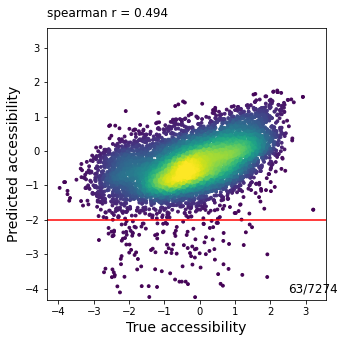

In [3]:
# Overall Spearman plot:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr

thresh = -2
x = y_test[np.where(y_pred>thresh)[0]]
y = y_pred[np.where(y_pred>thresh)[0]]
cor = spearmanr(x,y).correlation

z = gaussian_kde(np.vstack([y_test,y_pred]))(np.vstack([y_test,y_pred]))

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, c=z, s=8, vmax = 0.2)
plt.ylim(plt.axis()[0:2])
plt.axhline(y=thresh, color='r', linestyle='-')
plt.ylabel('Predicted accessibility', fontsize = 14)
plt.xlabel('True accessibility', fontsize = 14)
plt.text(-2.6, 3.8, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=12)
plt.text(3.2, -4.2, f'{len(np.where(y_pred<-3)[0])}/{len(y_pred)}', 
         ha='center', va='bottom',fontsize=12)
plt.show()

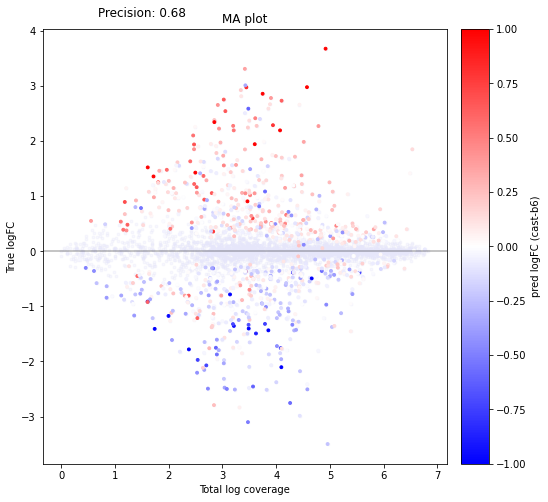

In [4]:
# MA plot (for allele specific prediction)
# One caveat is that you don't have a betabinomial test done for your data, so you can ignore the idx_sig bits and just use all indices
# Of course, the value of precision won't make much sense in that case
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_prec_rec(true_fc, pred_fc, sig_idx):     # function to calculate precision and recall
    temp = pred_fc[sig_idx]*true_fc[sig_idx]>0  # misclassifications are negative
    prec = np.sum(temp)/len(sig_idx)
    temp1 = pred_fc*true_fc>0
    rec = np.sum(temp)/np.sum(temp1)
    return prec, rec

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

_,_,_,_,_,temp = load_data_pairscan(ctype,dataset,'_noGC'+ident+'')        # load no GC dataset to get total log coverage
temp = (temp[:len(temp)//2]).T.reshape(-1)
totalcov = np.log2(2**temp[:len(y_test)//2]+2**temp[len(y_test)//2:]-1)
# beta-binomial significance
betabin_pvals = pd.read_csv(datadir+'significance/betabinom_result_combCounts_150bp_testOnly.csv')['p.adj']
idx_sig = np.where(betabin_pvals<0.05)[0]
# idx_sig = np.arange(len(totalcov))

ax.axhline(0, c='k', alpha=0.3)
ax.scatter(totalcov , true_fc, c = 'lavender', s = 8, alpha=0.3 )
a = ax.scatter(totalcov[idx_sig] , true_fc[idx_sig], c = pred_fc[idx_sig], cmap = 'bwr', s = 8, vmax=1, vmin=-1 )
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('pred logFC (cast-b6)')
ax.set_xlabel('Total log coverage')
ax.set_ylabel('True logFC')
ax.set_title('MA plot')
prec, rec = get_prec_rec(true_fc, pred_fc, idx_sig)
ax.text(1.5, 4.2, f'Precision: {prec:.2f}', 
         ha='center', va='bottom',fontsize=12)
plt.show()

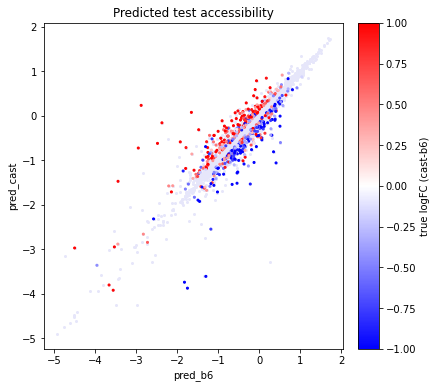

In [5]:
# Allele Specific predictions plot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

idx = np.where(np.abs(pred_fc)>0.1)[0]
idx = list(set(idx_sig).intersection(idx))

ax.scatter(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:], s = 4, c = 'lavender')
a = ax.scatter(y_pred[:len(y_pred)//2][idx], y_pred[len(y_pred)//2:][idx],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = true_fc[idx])
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('true logFC (cast-b6)')
ax.set_title('Predicted test accessibility')
ax.set_xlabel('pred_b6')
ax.set_ylabel('pred_cast')
plt.show()

KstestResult(statistic=0.589041095890411, pvalue=4.44027258466652e-12)


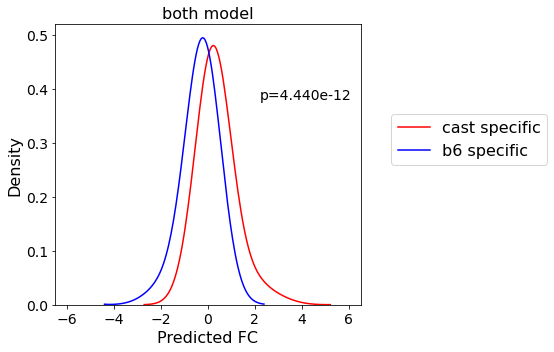

In [6]:
# KDE plot:
import seaborn as sns
from scipy.stats import ks_2samp

plt.rcParams['figure.figsize'] = 8, 5

# perform KS test on the peaks with foldchange in the top and bottom 2 percntile 
# pred_fc is the predicted foldchange and pred_fc_r is the predicted foldchange of the reverse complement
ks = ks_2samp(pred_fc[(true_fc)>np.percentile(true_fc, 98)],
              pred_fc[(true_fc)<np.percentile(true_fc, 2)])
print(ks)
sns.kdeplot(pred_fc[true_fc > np.percentile(true_fc, 98)], 
            color = 'red', bw = 0.7,legend = True,label="cast specific", linestyle="-")
sns.kdeplot(pred_fc[true_fc < np.percentile(true_fc, 2)], 
            color = 'blue', bw = 0.7,legend = True,label="b6 specific", linestyle="-")
plt.xlim(-6.5,6.5)
plt.xlabel('Predicted FC', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.title(dataset+' model', fontsize = 16)
plt.legend(fontsize = 16, loc = [1.1,0.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(2.2,0.38,'p={0:.3e}'.format(ks.pvalue), fontsize = 14)
plt.tight_layout()

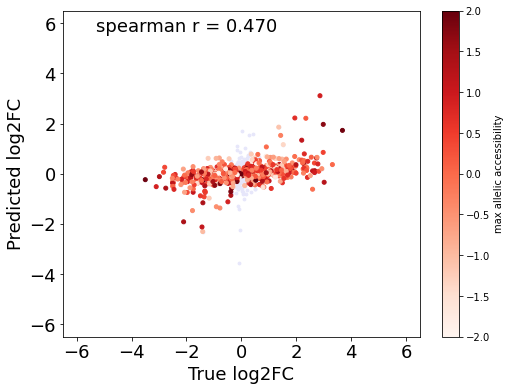

In [7]:
# Spearman plot for FC preds
plt.rcParams['figure.figsize'] = 8, 6

cor = spearmanr(true_fc[idx_sig], pred_fc[idx_sig]).correlation

plt.scatter(true_fc, pred_fc, s = 8, c = 'lavender')
plt.scatter(
           true_fc[idx_sig],pred_fc[idx_sig],
            vmax = 2, vmin = -2, cmap = 'Reds',s = 16, 
    c = np.max(np.array([y_test[:len(y_test)//2], y_test[len(y_test)//2:]]), axis=0)[idx_sig]
)
plt.ylabel('Predicted log2FC', fontsize = 18)
plt.xlabel('True log2FC', fontsize = 18)
plt.text(-2, 5.5, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=18)
cbar = plt.colorbar()
cbar.set_label('max allelic accessibility')
plt.xlim(-6.5,6.5)
plt.ylim(-6.5,6.5)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('')
plt.show()

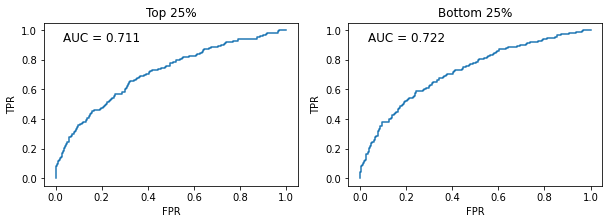

In [8]:
# Plot top 25 (cast specific) and bottom 25 (b6 specific) AUC
from utils import plot_auc

fig, ax = plt.subplots(1,2, figsize=(10,3))

sig_cutoff = 0.05
p = 25
sig_true_fc = true_fc[betabin_pvals<sig_cutoff]
sig_pred_fc = pred_fc[betabin_pvals<sig_cutoff]

plot_auc((sig_true_fc > np.percentile(sig_true_fc,100 - p))*1, sig_pred_fc, 'roc', ax[0])
ax[0].set_title(f'Top {p}%')
plot_auc((sig_true_fc < np.percentile(sig_true_fc,p))*1, -1*sig_pred_fc, 'roc', ax[1])
ax[1].set_title(f'Bottom {p}%')

plt.show()

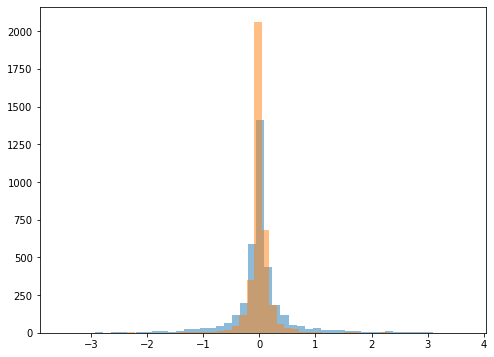

In [9]:
import matplotlib.pyplot as plt
# distribution of true and predicted log FC
plt.hist(true_fc, bins=50, alpha=0.5)
plt.hist(pred_fc, bins=50, alpha=0.5)
plt.show()

# Feature Attribution

In [10]:
# load the positive summits
from utils import unhot
flag = True    # True for specific peak, False for entire test set

if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{datadir}/summits{ident}.csv', header=None)
print(len(summits))

33143


In [11]:
# If doing attribution for entire test set - rarely used
if not flag:
    # load modfile for SNP and indel locations
    import gzip

    def get_loci(mods, c, summit):
        mod_c = [x for x in mods if '\t'+str(c)+'\t' in x]
        mod_c = pd.DataFrame([x.split('\t') for x in mod_c])
        mod_c[2] = mod_c[2].astype(int)
        temp = mod_c.iloc[np.where(np.logical_and(mod_c[2]>=summit-150, mod_c[2]<=summit+150))[0], :]
        # insert clever code to deal with dels
        loci = list(temp[2]-(summit-150)+1)
        return loci

    modfile = aligndir+'gen/cast.mod'
    with gzip.open(modfile,'rt') as f:
        mods = f.read().split('\n')
        mods = [x for x in mods if not x.startswith('#')][:-1]            # filter out header lines
        mods = [x for x in mods for c in chrom_test if '\t'+str(c)+'\t' in x]   # filter to only the chromosomes of interest
    
    # Get sorted fc for ranking of differentially accessible peaks
    # Use shortlist of significant peaks only
    temp = np.sort( np.abs(true_fc[idx_sig]) )[::-1]

In [12]:
# Code to print total parameters for sanity checks
import torch
from model import pairScan
model = pairScan(2,0.2)
x = torch.zeros((4,2,4,300))
_ = model(x)
print(sum([p.numel() for p in model.parameters()]))

64021


In [13]:
# FA code, just plug in the value of the summit in seq_name along with your trained model checkpoint
import torch
from loaders import load_data_pairscan
from model import pairScan, pairScanWrapper
from utils import trim_weights_dict
from captum.attr import IntegratedGradients
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
method = 'IG'

ident='_vi_150bp_tn5_aug'
SAVEPATH = f'{basedir}mouseASA/{ctype}/cast/ckpt_models/{modelname}_{dataset}_{batchsize}_{weight}{gc}{ident}.hdf5'
print(SAVEPATH)
ident='_vi_150bp'
model = pairScan(2, 0.2)
model.load_state_dict(torch.load(SAVEPATH))
supermodel = pairScanWrapper(model)
if method=='IG':
    ig = IntegratedGradients(supermodel)
    supermodel.to(DEVICE)
supermodel.eval()

if flag:
    # code in case the locus is out of test set
    # finding a particular summit eg. 12:4065711
    seq_name = '12:4065711'.split(':')
    c = int(seq_name[0])
    lims = [int(k) for k in seq_name[1].split('-')]
    print(c, lims)
    if len(lims)>1: # left and right limits given
        temp = summits.iloc[np.where(summits[0]==c)[0],:]
        temp = temp.iloc[list(set(np.where(temp[1]>lims[0])[0]).intersection(set(np.where(temp[1]<lims[1])[0])) )[0], 1]
    else:           # summit location given
        temp = lims[0]
    # find dataset with chromosome c
    i = [i for i in range(len(chroms)) if c in chroms[i]][0]
    print(f'found in {name[i]}..')
    x,y = [item for j,item in enumerate(load_data_pairscan(ctype,'both',gc+ident,get_rc=False,frac=0.)) if (j==i or j==i+3)]
    x = x.reshape(-1, x.shape[-2], x.shape[-1])
    y = y.reshape(-1)
    
    # accumulate peak numbers in order to get index in x of particular summit
    idx = 0
    for chrom in chroms[i]:
        if chrom != c:
            idx += len(np.where(summits[0]==chrom)[0])
        else:
            chromsummits = summits.iloc[np.where(summits[0]==chrom)[0],:]
            idx += np.where(chromsummits[1]==temp)[0][0]
            break
    
    x = x[[idx*2,idx*2+1]]    # (2,300,4)
    y = y[[idx*2,idx*2+1]]    # (2,)
    print(y[1]-y[0])
    x_dna = unhot(x)
    x = np.expand_dims(x, axis=0)  # (1,2,300,4)

else:  # for test set
    _,_,x,_,_,y = load_data(ctype, 'both', gc+ident, get_rc=False, frac=0.)
    y = y.reshape(-1)
    x_dna = unhot(x.reshape(-1, x.shape[-2], x.shape[-1]))

    chromsummits = []
    for i in chrom_test:
        chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
    chromsummits = np.concatenate(chromsummits)

# x: one-hot encoded 300bp sequence inputs with shape (n, 2, 300, 4)
if method=='IG':
    attr = []
    for i in tqdm( range(0, len(x), int(batchsize)) ):
        test_input_tensor = torch.from_numpy(x[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(2,3).to(DEVICE)
        test_input_tensor = test_input_tensor.view(-1, x.shape[-1], x.shape[-2])
        test_input_tensor.requires_grad_()
        attr.append(ig.attribute(test_input_tensor).detach().cpu().numpy())
    attr = np.concatenate(attr)

attr = attr.reshape(-1,2,attr.shape[-2],attr.shape[-1])   # get in same shape as x

/data/leslie/shared/ASA/mouseASA/cd8/cast/ckpt_models/ad_both_32_1.0_vi_150bp_tn5_aug.hdf5
12 [4065711]
found in train..
-4.005664461672344


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
a = model(torch.from_numpy(x).type(torch.FloatTensor).transpose(2,3).to(DEVICE))
print(a[0,1]-a[0,0])

tensor(-0.2362, device='cuda:0', grad_fn=<SubBackward0>)


chr12: 4065561-4065861
True Log2fc (cast/b6):-4.01	 Predicted:-0.24
b6       IG


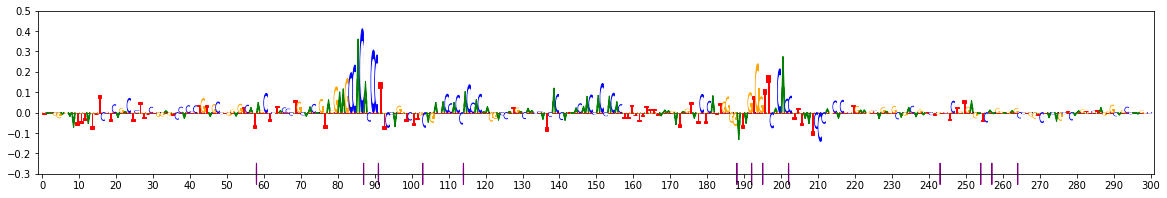

cast     IG


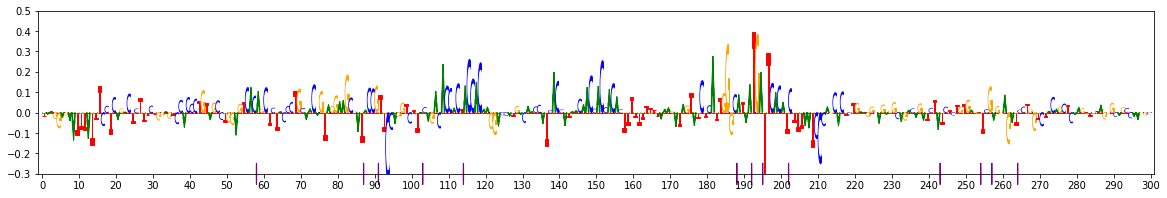

In [15]:
import deeplift
from deeplift.visualization import viz_sequence
import matplotlib.patches

if flag:
    i=0
    print(f'chr{c}: {temp-seqlen//2}-{temp+seqlen//2}')
    print('True Log2fc (cast/b6):{:.2f}\t Predicted:{:.2f}'.format(y[1]-y[0], a[0,1]-a[0,0]))
    # snp_idx, to be replaced with code to find SNP locations
    idx = [58, 87, 91, 103, 114, 188, 192, 195, 202, 243, 254, 257, 264] #12:4065711
#     idx=[24, 39, 49, 73, 156, 199] #19:53699992
#     idx = [2,3,19,106,142,233] #17:27375655
else:
    rank = 20       # fold change rank of true accessibility change
    i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
    if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
        c = chrom_test[1]
    else:
        c = chrom_test[0]
    
    # get locations of SNPs and indels
    idx = get_loci(mods, c, chromsummits[i])

    print(f'chr{c}: {chromsummits[i]-seqlen//2}-{chromsummits[i]+seqlen//2}')
    print('SNP/Indel location:', idx)
    print('True Log2fc (cast/b6):{:.2f}\t Predicted:{:.2f}'.format(true_fc[i]))

seq_b6 = x_dna[i]
seq_ca = x_dna[len(x_dna)//2+i]

ylims = [-0.3,0.5]
scores = x[i]*attr[i].transpose((0,2,1))   # (2,300,4) scores for b6,ca
print('b6      ', method)
viz_sequence.plot_weights(scores[0], subticks_frequency=10, figsize = (20,3), snp_list=idx, ylims=ylims)
print('cast    ', method)
viz_sequence.plot_weights(scores[1], subticks_frequency=10, figsize = (20,3), snp_list=idx, ylims=ylims)

In [17]:
seq_b6

'TAAGGAGAATTTATTTCCTCAGACTCTTTCTGGAGTCCACCCTGTAGCCTGGAGTCATAGCTCTACCCTGCAACAGTAGGAAGCCACACCCTTCCAGGTCTTGCAGACACCACCACCACAAGGACCATGACAACCATCACCATAACAACCACCACACTTTTTTTTTTAAAGATAGTATCTCATTGGGGATAGTGGTTCACACCTTTAATCCCAGCACTCTGAAGGCAGAGGCAGACAGATCTGTCTCTGTGAGATCAAGGAGAGCCTGGTCTACAGCTCAAGTTCTAGGGCAGCCAAGGC'

In [18]:
seq_ca

'TAAGGAGAATTTATTTCCTCAGACTCTTTCTGGAGTCCACCCTGTAGCCTGGAGTCACAGCTCTACCCTGCAACAGTAGGAAGCCATACCGTTCCAGGTCTTACAGACACCACTACCACAAGGACCATGACAACCATCACCATAACAACCACCACACTTTTTTTTTTAAAGATAGTATCTCATTGGGCATAATGATTCACATCTTTAATCCCAGCACTCTGAAGGCAGAGGCAGACAGATCTATCTCTGTGAGTTCGAGGAGATCCTGGTCTACAGCTCAAGTTCTAGGGCAGCCAAGGC'

In [19]:
len('GGGAAGTCTGAGCACTGCAGCT')

22

In [20]:
idx1=195
idx2=201
print(seq_b6[idx1-1:idx2])
print(seq_ca[idx1-1:idx2])

GTTCACA
ATTCACA


## CUT&RUN Pileups

In [17]:
profile = dict()
with h5py.File(datadir+'cutrun/tbet/profiles.h5','r') as f:
    profile['b6'] = f['profile_b6'][()]
    profile['cast'] = f['profile_cast'][()]

profile['summits'] = pd.read_csv(datadir+'cutrun/tbet/summits_tbetfiltered.csv')

chr             19
summit    53699992
diff            45
b6               2
ca              47
Name: 14, dtype: int64


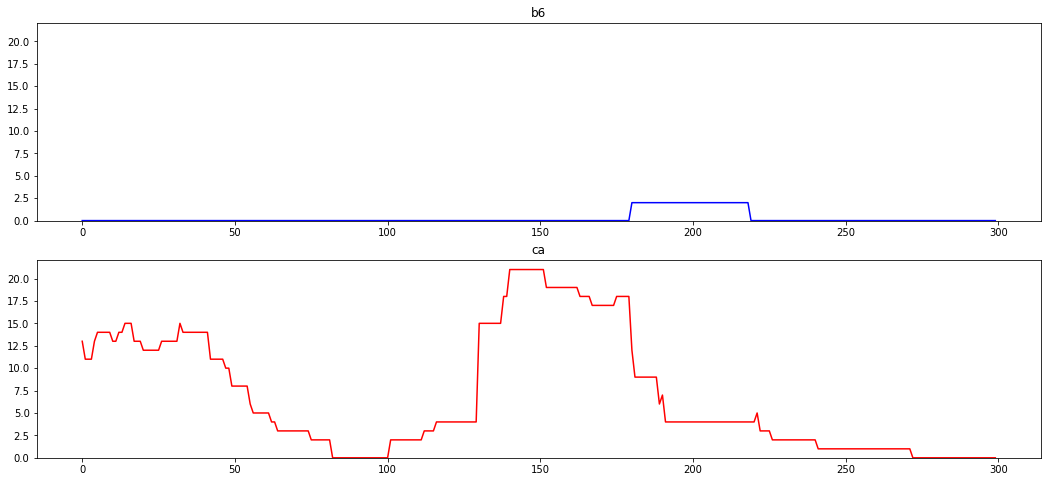

In [18]:
i = np.where(profile['summits']['summit']==53699992)[0][0]       # index in profile summits
fig, ax = plt.subplots(2,1, figsize=(18,8))
ylim = np.max(np.concatenate((profile['b6'][i],profile['cast'][i])))*1.05
ax[0].plot(profile['b6'][i], color='b')
ax[1].plot(profile['cast'][i], color='r')
ax[0].set_title('b6')
ax[1].set_title('ca')
ax[0].set_ylim([0,ylim])
ax[1].set_ylim([0,ylim])
# plt.suptitle('Allele-specific T-bet Occupancy')
print(profile['summits'].iloc[i])
plt.show()

# FA Metric

In [75]:
# profile['summits'] = pd.read_csv(datadir+'cutrun/tbet/summits_overlap.csv')         # all overlaps
profile['summits'] = pd.read_csv(datadir+'cutrun/tbet/summits_tbetfiltered.csv')    # shortlisted differential occupancy

In [76]:
# Make curated set corresponding to exclusive Tbet occupancy
x = []
y = []

temp = []
for i in range(len(name)):
    temp.append([item for j,item in enumerate(load_data(ctype,'both',gc+ident,get_rc=False,frac=0.)) if (j==i or j==i+3)])

for k,(c,summit) in enumerate(zip(profile['summits']['chr'], profile['summits']['summit'])):
    i = [i for i in range(len(chroms)) if c in chroms[i]][0]
    # accumulate peak numbers in order to get index in x of particular summit
    idx = 0
    for chrom in chroms[i]:
        if chrom != c:
            idx += len(np.where(summits[0]==chrom)[0])
        else:
            chromsummits = summits.iloc[np.where(summits[0]==chrom)[0],:]
            idx += np.where(chromsummits[1]==summit)[0][0]
            break
    x.append(temp[i][0][idx])
    y.append(temp[i][1][idx])
x = np.stack(x)
y = np.stack(y)

In [77]:
# For the peak list, find the location of the Tbet motif hits, if any
fimo = pd.concat((pd.read_csv(f'{datadir}fimo/fimo_b6_train.tsv', sep='\t').iloc[:-3,:],
                     pd.read_csv(f'{datadir}fimo/fimo_b6_val.tsv', sep='\t').iloc[:-3,:],
                     pd.read_csv(f'{datadir}fimo/fimo_b6_test.tsv', sep='\t').iloc[:-3,:],
                     pd.read_csv(f'{datadir}fimo/fimo_ca_train.tsv', sep='\t').iloc[:-3,:],
                     pd.read_csv(f'{datadir}fimo/fimo_ca_val.tsv', sep='\t').iloc[:-3,:],
                     pd.read_csv(f'{datadir}fimo/fimo_ca_test.tsv', sep='\t').iloc[:-3,:])).reset_index(drop=True)

locs = []
for c,summit in zip(profile['summits']['chr'], profile['summits']['summit']):
    seq_name = str(c)+':'+str(summit)
    idx = np.where(fimo['sequence_name']==seq_name)[0]
    if len(idx):            # if we get a hit on either allele
        idx = idx[0]        # get the first FIMO hit we see
        locs.append([int(fimo.iloc[idx, 3]), int(fimo.iloc[idx, 4])])
    else:
        locs.append([])

In [78]:
# Perform FA on x
attr = []
for i in tqdm( range(0, len(x), int(batchsize)*4) ):
    test_input_tensor = torch.from_numpy(x[i:i+int(batchsize)*4]).type(torch.FloatTensor).transpose(2,3).to(DEVICE)
    test_input_tensor = test_input_tensor.view(-1, x.shape[-1], x.shape[-2])
    test_input_tensor.requires_grad_()
    attr.append(ig.attribute(test_input_tensor).detach().cpu().numpy().reshape(-1, 2, x.shape[-1], x.shape[-2]))
attr = np.concatenate(attr)

  0%|          | 0/7 [00:00<?, ?it/s]

In [79]:
# FA evaluation metric code - evaluated on the ATAC summits with exclusive Tbet occupancy (the ranked list)
S1 = []
S2 = []
S3 = []
for i in range(len(attr)):
    # normalized motif imbalance [-1,1] for specific locus  b6-ca
    loc = locs[i]                               # motif location on the 300bp region locus
    if len(loc):
        S1.append( (np.sum(attr[i][0][:,loc[0]:loc[1]+1]) + np.sum(attr[i][1][:,loc[0]:loc[1]+1])) )
    else:
        S1.append(0.)
S1 = np.array(S1)
# S1/=np.max(np.abs(S1))
        
# fold change for set b6-ca
S2 = y[:,0]-y[:,1]
# S2/=np.max(np.abs(S2))

# cutrun imbalance for set b6-ca
S3 = np.array(profile['summits']['b6'] - profile['summits']['ca'])
# S3 = S3/np.max(np.abs(S3))

# Finally, put it together into an element wise FA metric
# sign = np.array([1 if np.abs(np.sum(np.sign([S1[i], S2[i], S3[i]])))==3 else -1 for i in range(len(attr))])    # consistency between scores only if 3 or -3
# F = sign*np.abs(S1*S2*S3)
# # remove the zeros
# F = F[np.nonzero(F)]
# F/=np.abs(np.max(F))

In [55]:
temp1=S1

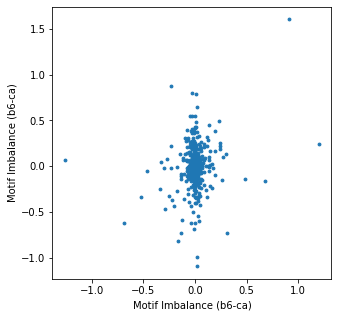

In [63]:
# Motif imbalance Model1 vs Model2
plt.figure(figsize=(5,5))
# cor = spearmanr(profile['summits']['b6'][idx]+profile['summits']['b6'][idx], S1[idx]).correlation
plt.scatter(S1, temp1, s=8)
plt.xlabel('Motif Imbalance (b6-ca)')
plt.ylabel('Motif Imbalance (b6-ca)')
# plt.xlim([-0.1,2.7])
# plt.ylim([-10,245])
# plt.text(150, 4.0, 'spearman r = {:.3f}'.format(cor), 
#          ha='center', va='bottom',fontsize=18)
plt.show()

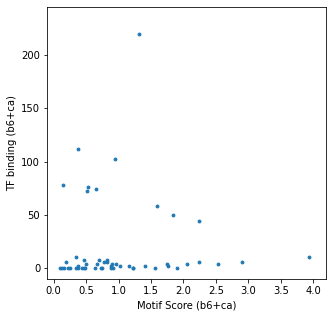

In [80]:
# Total binding vs. motif score association
idx = np.where(S1>0.)[0]
# cor = spearmanr(profile['summits']['b6'][idx]+profile['summits']['b6'][idx], S1[idx]).correlation
plt.figure(figsize=(5,5))
plt.scatter(S1[idx], profile['summits']['b6'][idx]+profile['summits']['b6'][idx], s=8)
plt.xlabel('Motif Score (b6+ca)')
plt.ylabel('TF binding (b6+ca)')
plt.xlim([-0.1,4.2])
plt.ylim([-10,245])
# plt.text(150, 4.0, 'spearman r = {:.3f}'.format(cor), 
#          ha='center', va='bottom',fontsize=18)
plt.show()

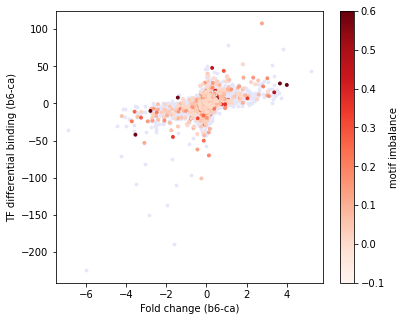

In [141]:
# Visualize fold change vs differential TF occupancy
idx = [i for i in range(len(locs)) if len(locs[i])==2]
plt.figure(figsize=(6,5))
plt.scatter(S2, S3, c='lavender', s=8)
plt.scatter(S2[idx], S3[idx], c=np.abs(S1)[idx], s=8, cmap='Reds', vmin=-0.1, vmax=0.6)
plt.xlabel('Fold change (b6-ca)')
plt.ylabel('TF differential binding (b6-ca)')
cbar = plt.colorbar()
cbar.set_label('motif imbalance')
plt.show()

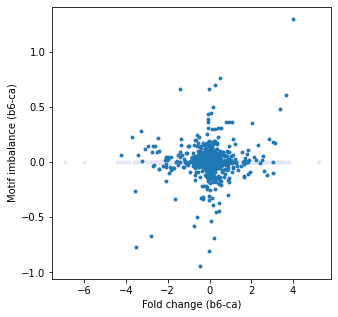

In [138]:
plt.figure(figsize=(5,5))
plt.scatter(S2, S1, c='lavender', s=8)
plt.scatter(S2[idx], S1[idx], s=8)
plt.xlabel('Fold change (b6-ca)')
plt.ylabel('Motif imbalance (b6-ca)')
plt.show()

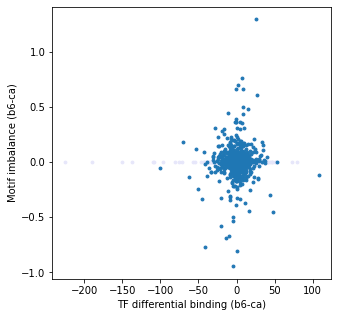

In [139]:
plt.figure(figsize=(5,5))
plt.scatter(S3, S1, c='lavender', s=8)
plt.scatter(S3[idx], S1[idx], s=8)
plt.xlabel('TF differential binding (b6-ca)')
plt.ylabel('Motif imbalance (b6-ca)')
plt.show()

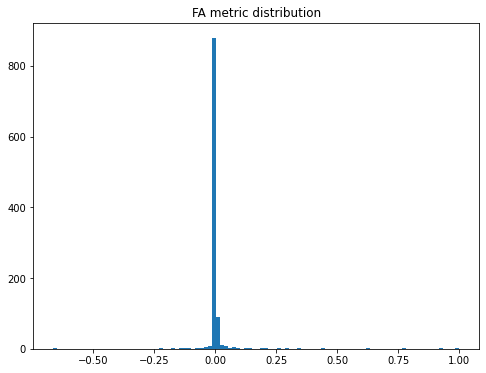

In [40]:
plt.hist(F, bins=100)
plt.title('FA metric distribution')
plt.show()

## Check RC variability

In [3]:
from run import load_data
modelname = 'ad'
dataset = 'both'
use_prior = '1'
batchsize = '16'
gc = ''
ident = '_vi_150bp'

# predspath = f'{basedir}mouseASA/{ctype}/preds/{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}_fc.npy'
predspath = f'{basedir}mouseASA/{ctype}/preds/test_11.npy'

print(predspath)
print(datetime.datetime.fromtimestamp(os.path.getmtime(predspath)))
pred_back = np.load(predspath)  # (7274,)
_,_,x_test,_,_,y_test = load_data(ctype,dataset,gc+ident,get_rc=True,frac=0.)

/data/leslie/shared/ASA/mouseASA/data/cd8/preds/test_11.npy
2023-05-01 00:19:21.031070


In [4]:
import torch
from model import pairScan
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

SAVEPATH = f'{basedir}mouseASA/{ctype}/ckpt_models/test_11.hdf5'
model = pairScan(2, 0.2)
model.load_state_dict(torch.load(SAVEPATH))
model.to(DEVICE)
model.eval()

pairScan(
  (seq_extractor): Sequential(
    (0): Conv1d(4, 16, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (4): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): Linear(in_features=32, out_features=32, bias=True)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
        (output_linear): Linear(in_features=32, out_features=32, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=32, out_fe

In [5]:
from tqdm.notebook import tqdm
y_pred = []
fc_pred = []
B = int(batchsize)
with torch.no_grad():
    for i in tqdm( range(0, len(x_test), B) ):
        temp = model(torch.from_numpy(x_test[i:i+B]).type(torch.FloatTensor).transpose(2,3).to(DEVICE))
        y_pred.append(temp[0].detach().cpu().numpy())
        fc_pred.append(temp[1].detach().cpu().numpy())
    y_pred = np.concatenate(y_pred)
    fc_pred = np.concatenate(fc_pred)

  0%|          | 0/455 [00:00<?, ?it/s]

In [19]:
betabin_pvals = pd.read_csv(datadir+'significance/betabinom_result_combCounts_150bp_testOnly.csv')['p.adj']
idx_sig = np.where(betabin_pvals<0.05)[0]

3637

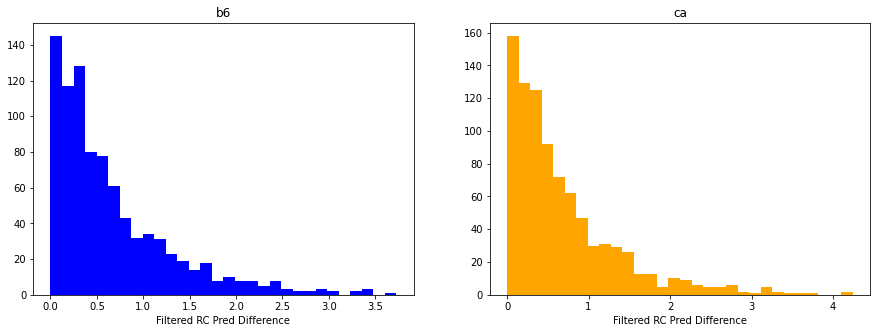

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(abs(y_pred[:len(y_pred)//2,0]-y_pred[len(y_pred)//2:,0])[idx_sig], bins=30, color='blue')
ax[1].hist(abs(y_pred[:len(y_pred)//2,1]-y_pred[len(y_pred)//2:,1])[idx_sig], bins=30, color='orange')
ax[0].set_xlabel('Filtered RC Pred Difference')
ax[0].set_title('b6')
ax[1].set_title('ca')
ax[1].set_xlabel('Filtered RC Pred Difference')
plt.show()